### Time Series Anomaly Detection Using Prophet In Python
https://grabngoinfo.com/time-series-anomaly-detection-using-prophet-in-python/

In [1]:
# Install libraries
#!pip install yfinance prophet
# Get time series data
import yfinance as yf
# Prophet model for time series forecast
from prophet import Prophet
# Data processing
import numpy as np
import pandas as pd
# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
# Data start date
start_date = '2020-01-02'
# Data end date. yfinance excludes the end date, so we need to add one day to the last day of data
end_date = '2022-01-01' 

In [6]:
# Pull close data from Yahoo Finance for the list of tickers
ticker_list = ['GOOG']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]
# Change column names
data = data.reset_index()
data.columns = ['ds', 'y']
# Remove timezone from timestamp - this code was added after yfiance package update on date format
data['ds'] = data['ds'].dt.tz_localize(None)
# Take a look at the data
data.head()

[*********************100%***********************]  1 of 1 completed


,ds,y
0,2020-01-02,68.368500
1,2020-01-03,68.032997
2,2020-01-06,69.710503
3,2020-01-07,69.667000
4,2020-01-08,70.216003


In [8]:
# Information on the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      505 non-null    datetime64[ns]
 1   y       505 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 KB


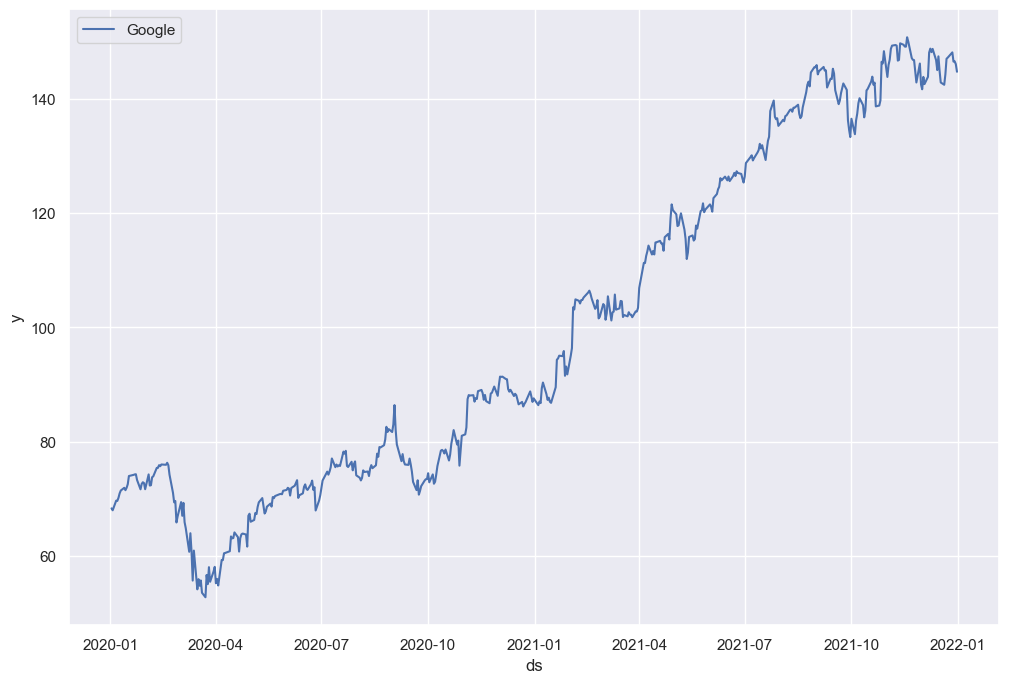

In [9]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data['ds'], y=data['y'])
plt.legend(['Google'])

In [10]:
# Add seasonality
model = Prophet(interval_width=0.99, yearly_seasonality=True, weekly_seasonality=True)
# Fit the model on the training dataset
model.fit(data)

23:11:19 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing


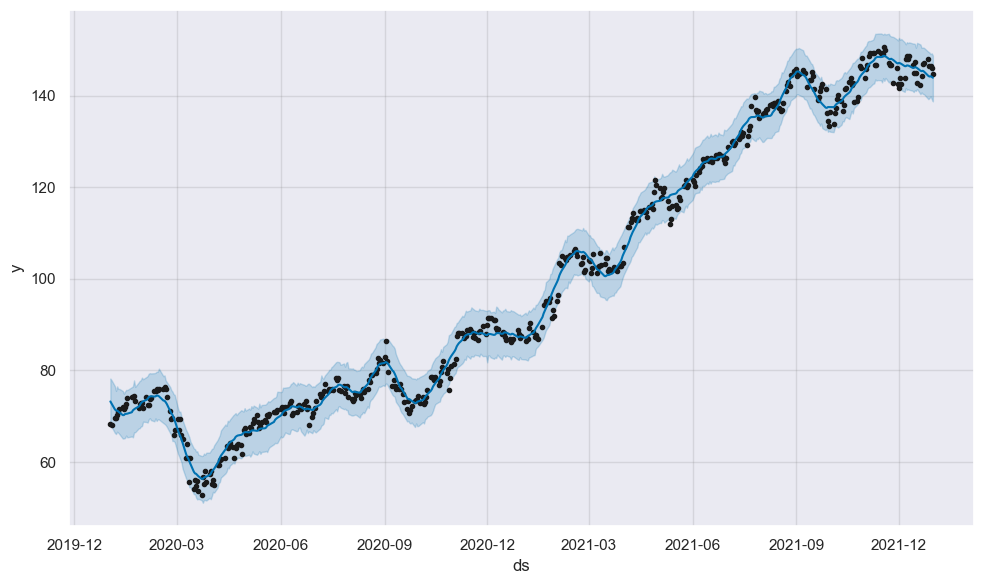

In [11]:
# Make prediction
forecast = model.predict(data)
# Visualize the forecast
model.plot(forecast); # Add semi-colon to remove the duplicated chart

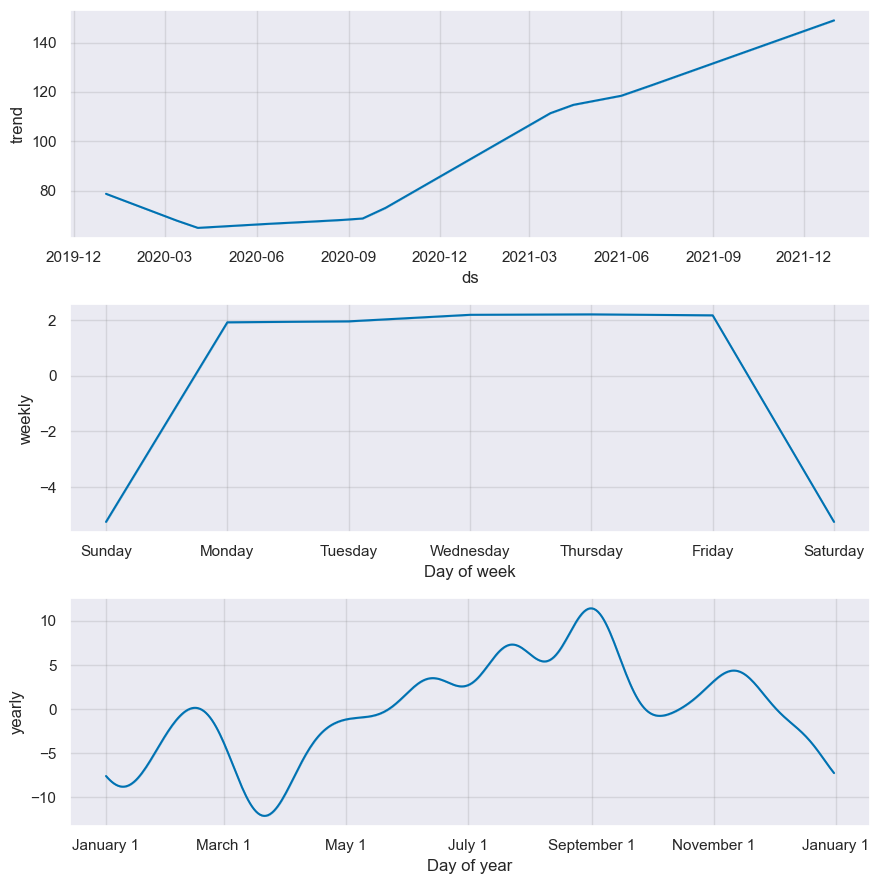

In [12]:
# Visualize the forecast components
model.plot_components(forecast);

In [13]:
# Merge actual and predicted values
performance = pd.merge(data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
# Check MAE value
performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
print(f'The MAE for the model is {performance_MAE}')
# Check MAPE value
performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
print(f'The MAPE for the model is {performance_MAPE}')

The MAE for the model is 1.576420683835356
The MAPE for the model is 0.017018163535677446


In [14]:
# Create an anomaly indicator
performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)
# Check the number of anomalies
performance['anomaly'].value_counts()

0    498
1      7
Name: anomaly, dtype: int64

In [15]:
# Take a look at the anomalies
anomalies = performance[performance['anomaly']==1].sort_values(by='ds')
anomalies

,ds,y,yhat,yhat_lower,yhat_upper,anomaly
208,2020-10-28,75.831001,82.235747,76.965958,87.702360,1
269,2021-01-27,91.539497,96.622383,91.827499,101.186966,1
271,2021-01-29,91.787003,97.827257,92.791396,102.714491,1
342,2021-05-12,111.954002,118.222594,113.038839,123.235184,1
343,2021-05-13,113.098503,118.351162,113.518998,123.320837,1
480,2021-11-26,142.806000,147.764678,143.050917,152.808965,1
483,2021-12-01,141.617996,147.152581,141.977559,152.617545,1


<Axes: xlabel='ds', ylabel='y'>

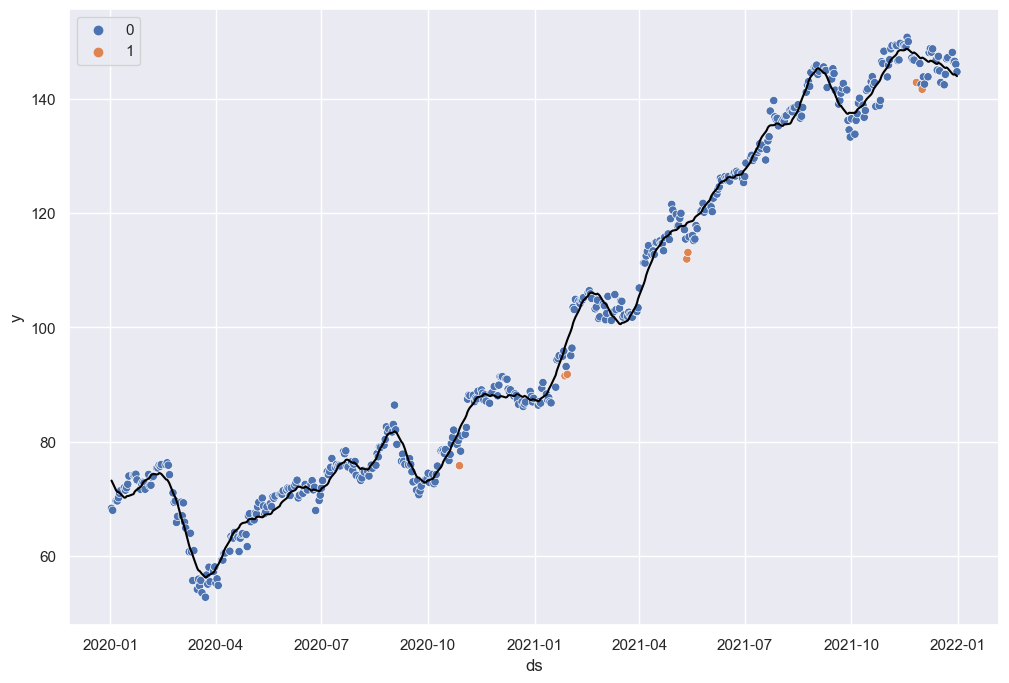

In [16]:
# Visualize the anomalies
sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly')
sns.lineplot(x='ds', y='yhat', data=performance, color='black')